In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import LazyConfig
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

import deepdisc.astrodet.astrodet as toolkit
from deepdisc.astrodet import detectron as detectron_addons

from deepdisc.data_format.file_io import DDLoader
from deepdisc.data_format.annotation_functions.annotate_hsc import annotate_hsc

In [2]:
# Print the versions to test the imports and so we know what works
print(detectron2.__version__)
print(np.__version__)
print(cv2.__version__)

0.6
1.23.4
4.6.0


In [3]:
# Prettify the plotting
#from astrodet.astrodet import set_mpl_style

toolkit.set_mpl_style()

### Register HSC training data

First, format the HSC data using training_data.ipynb.  It will need to be partitioned in "train, test and val" directories

The flexible `DDLoader` class can be used to load data from a generic directory 
structure into a user-defined output structure of metadata.

For a custom dataset, this dictionary needs to be populated correctly for your data.

You will need to change directory paths!

In [4]:
dirpath = "/home/shared/hsc/HSC/HSC_DR3/data/"
output_dir = "./output/hsc"

In [5]:
# this block is for debug purposes, set to -1 to include every sample
sampleNumbers = 20

We initialize a `DDLoader` for the train and test datasets. The `DDLoader.generate_filedict` function reads in data from a directory structure, the
kwargs will need to be tuned to the particular structure of a given directory.
This returns a dictionary of file-level information that can be passed along
to an annotation generation function.

In [6]:
# Generate the dictionary of file paths
test_loader = DDLoader().generate_filedict(os.path.join(dirpath, 'test'), ['G', 'R', 'I'], '*_scarlet_img.fits', '*_scarlet_segmask.fits', n_samples=sampleNumbers)
train_loader = DDLoader().generate_filedict(os.path.join(dirpath, 'train'), ['G', 'R', 'I'], '*_scarlet_img.fits', '*_scarlet_segmask.fits', n_samples=sampleNumbers)

For detectron2 to read the data, it must be in a dictionary format. The
`DDLoader` instances established above can generate annotations in dictionary
format using the `DDLoader.generate_dataset_dict` function. This function
passes a user-defined annotation function along to the files, using the 
filedicts generated above.

In this case, we have a pre-made annotation function for HSC data,
`annotate_hsc, which is passed along.

However, this step can take a few minutes, and so we recommend only running it once and saving the dictionary data as a json file that can be read in at the beginning of your code.  

Now, we register the dataset following the detectron2 documention.

In [7]:
DatasetCatalog.register("astro_train", lambda: train_loader.generate_dataset_dict(annotate_hsc).get_dataset())
astrotrain_metadata = MetadataCatalog.get("astro_train").set(thing_classes=["object"])
DatasetCatalog.register("astro_test", lambda: test_loader.generate_dataset_dict(annotate_hsc).get_dataset())
astrotest_metadata = MetadataCatalog.get("astro_test").set(thing_classes=["object"])

dataset_dicts = {}
for i, d in enumerate(["train","test"]):
    print(f"Loading {d}")
    loader = DDLoader().generate_filedict(os.path.join(dirpath, d), ['G', 'R', 'I'], '*_scarlet_img.fits', '*_scarlet_segmask.fits', n_samples=sampleNumbers)
    dataset_dicts[d] = loader.generate_dataset_dict(annotate_hsc).get_dataset()

Loading train
Loading test


In [ ]:
# code snippet for unregistering if you want to change something
"""
if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    #MetadataCatalog.remove("astro_train")
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    #MetadataCatalog.remove("astro_test")

if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")
    #MetadataCatalog.remove("astro_val")

"""

### A note on classes

In this demo, we assume one class for all objects.

### Visualize Ground Truth Examples

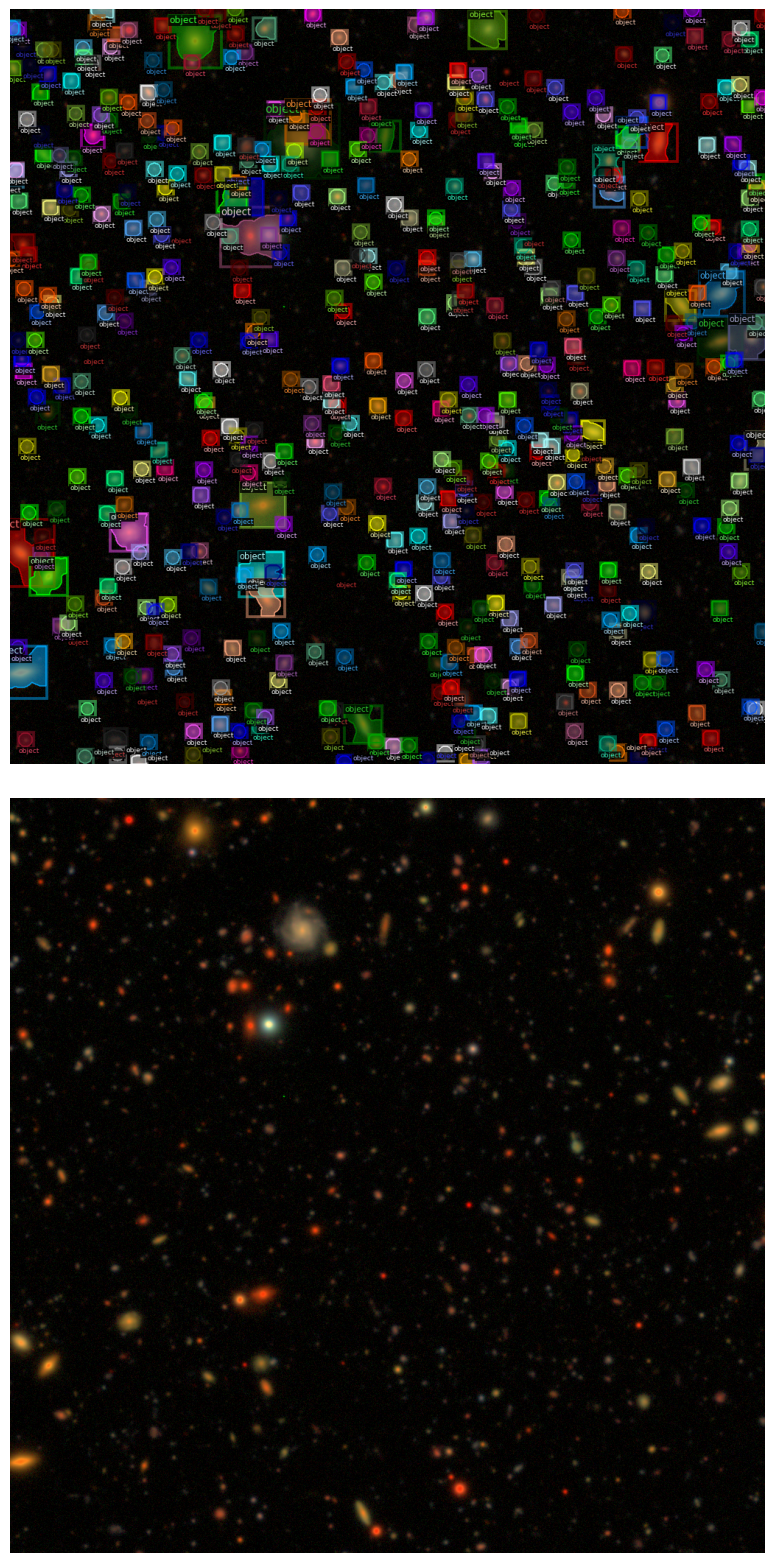

In [8]:
nsample = 1
maxInd = sampleNumbers
if maxInd == -1:
    maxInd = 20
randInd = np.random.randint(0, maxInd, nsample)
fig = plt.figure(figsize=(8, 8 * nsample * 2))
i = 0
for ind in randInd:
    # Need to increase ceil_percentile if the data are saturating!
    d = dataset_dicts["train"][ind]
    filenames = [d["filename_G"], d["filename_R"], d["filename_I"]]
    img = toolkit.read_image_hsc(filenames, normalize="astrolupton", stretch=0.5, Q=10)
    visualizer = Visualizer(img, metadata=astrotrain_metadata)
    out = visualizer.draw_dataset_dict(d)
    ax1 = plt.subplot(nsample * 2, 1, 2 * i + 1)
    ax1.imshow(out.get_image(), origin="upper")
    ax1.axis("off")
    ax2 = plt.subplot(nsample * 2, 1, 2 * i + 2)
    ax2.imshow(img)
    ax2.axis("off")
    i += 1

plt.tight_layout()

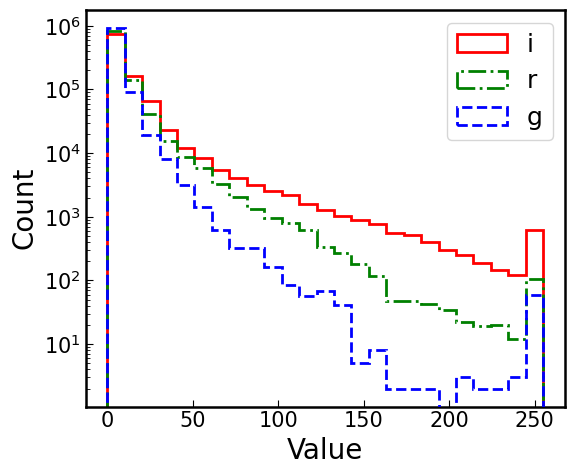

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
# 91,28, 38 are  bad examples
d = dataset_dicts["train"][1]
filenames = [d["filename_G"], d["filename_R"], d["filename_I"]]

img = toolkit.read_image_hsc(filenames, normalize="astrolupton", stretch=0.5, Q=10)
ax.hist(img[:, :, 0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1, label="i")
ax.hist(
    img[:, :, 1].flatten(),
    histtype="step",
    bins=bins,
    log=True,
    color="g",
    lw=2,
    linestyle="-.",
    zorder=2,
    label="r",
)
ax.hist(
    img[:, :, 2].flatten(),
    histtype="step",
    bins=bins,
    log=True,
    color="b",
    lw=2,
    linestyle="dashed",
    zorder=3,
    label="g",
)
ax.set_xlabel("Value", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.legend(fontsize=18)

fig.tight_layout()

### Data Loading and Augmentation

Below, we create the function train_mapper, which takes one of the metadata dictionaries, reads in the corresponding image, and applies custom
augmentations.  It will output a new dictionary that will be fed into the model. You can see an example of the augmentations working below.

In [10]:
from deepdisc.astrodet.detectron import _transform_to_aug


def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    filenames = [dataset_dict["filename_G"], dataset_dict["filename_R"], dataset_dict["filename_I"]]
    image = toolkit.read_image_hsc(filenames, normalize="astrolupton", stretch=0.5, Q=10)

    augs = detectron_addons.KRandomAugmentationList(
        [
            # my custom augs
            T.RandomRotation([-90, 90, 180], sample_style="choice"),
            T.RandomFlip(prob=0.5),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            # detectron_addons.CustomAug(gaussblur,prob=1.0),
            # detectron_addons.CustomAug(addelementwise,prob=1.0)
            # CustomAug(white),
        ],
        k=-1,
        cropaug=_transform_to_aug(
            T.CropTransform(
                image.shape[1] // 4, image.shape[0] // 4, image.shape[1] // 2, image.shape[0] // 2
            )
        ),
    )

    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]

    instances = utils.annotations_to_instances(annos, image.shape[1:])
    instances = utils.filter_empty_instances(instances)

    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 1050,
        "width": 1050,
        "image_id": dataset_dict["image_id"],
        "instances": instances,
    }

(512, 512, 3)


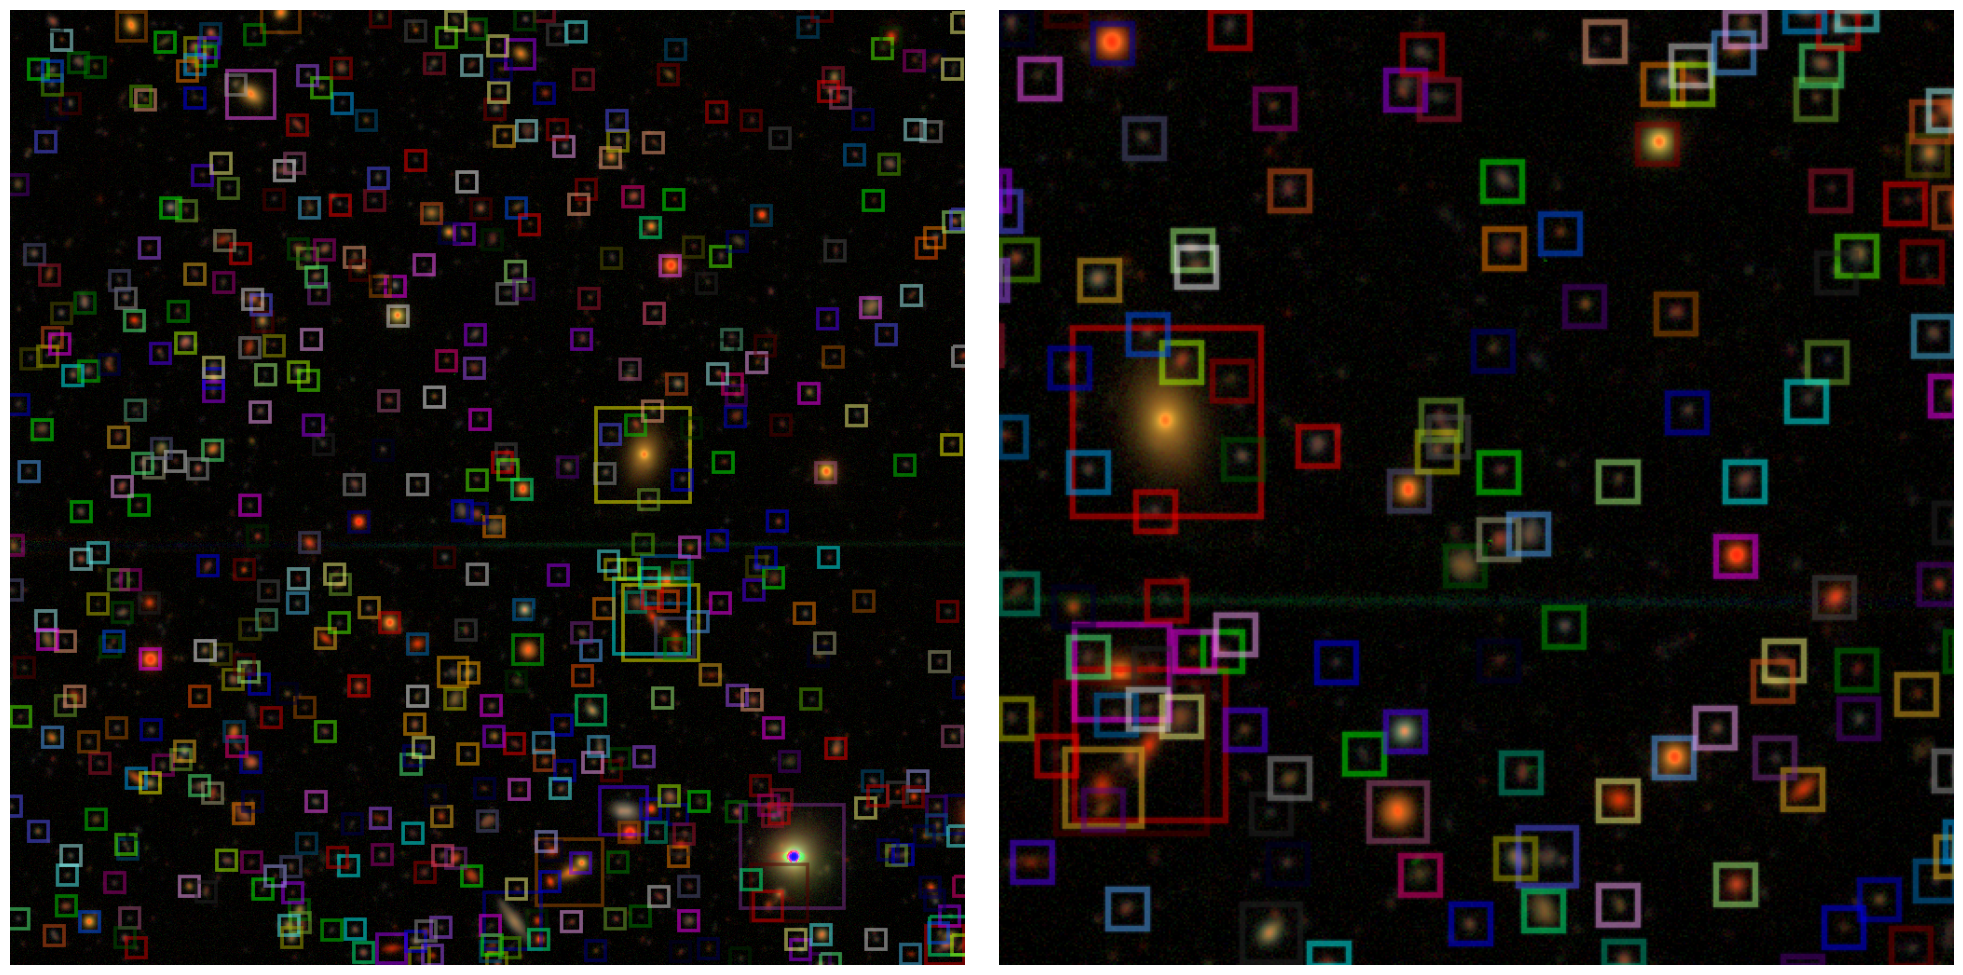

In [11]:
from detectron2.structures import BoxMode

fig, axs = plt.subplots(1, 2, figsize=(10 * 2, 10))

dictionary = iter(dataset_dicts["train"])
d = next(dictionary)
filenames = [d["filename_G"], d["filename_R"], d["filename_I"]]

img = toolkit.read_image_hsc(filenames, normalize="astrolupton", stretch=0.5, Q=10)
visualizer = Visualizer(img, metadata=astrotrain_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis("off")

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astrotrain_metadata, scale=1)
print(img_aug.shape)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis("off")
fig.tight_layout()
fig.show()

You may have noticed the `train_mapper` function above is similar to the one used in the demo_decam notebook.  We've created the `ImageReader` and `DataMapper` class to generalize the dataloading.  You can check out the code to see the details.  We will use these classes during training

In [ ]:
import deepdisc.model.loaders as loaders
from deepdisc.data_format.image_readers import HSCImageReader
from deepdisc.data_format.augment_image import train_augs

In [ ]:
#This function will take a dictionary and return the necessary file path(s) to read in the data

def key_mapper(dataset_dict):
    key = [dataset_dict["filename_G"], dataset_dict["filename_R"], dataset_dict["filename_I"]]
    return key

In [ ]:
tm = loaders.DictMapper                                # DictMapper class to read in the dictionaries and reformat them for the model
reader = HSCImageReader(norm="lupton",stretch=0.5,     # ImageReader class to read the image from memory and apply contrast scalings
                        Q=10, bandlist=[0,1,2])        
mapper = tm(reader, key_mapper, train_augs).map_data   # Map (reformat) the data

In [ ]:
from detectron2.structures import BoxMode

fig, axs = plt.subplots(1, 2, figsize=(10 * 2, 10))

dictionary = iter(dataset_dicts["train"])
d = next(dictionary)
img = reader(key_mapper(d))

visualizer = Visualizer(img, metadata=astrotrain_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis("off")

aug_d = mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astrotrain_metadata, scale=1)
print(img_aug.shape)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis("off")
fig.tight_layout()
fig.show()

### Training

We prepare for training by intializing a config object.  The we can take the intial weights from the pre-trained models in the model zoo.
This setup is for demo purposes, so it does not follow a full training schedule.

In [ ]:
from deepdisc.training.trainers import (
    return_evallosshook,
    return_lazy_trainer,
    return_optimizer,
    return_savehook,
    return_schedulerhook,
)

from deepdisc.model.models import return_lazy_model

import deepdisc.model.loaders as loaders
from deepdisc.data_format.image_readers import HSCImageReader


In [ ]:
cfgfile = '../configs/solo/demo_r50_hsc.py'          # The config file which contains information about the model 
cfg = LazyConfig.load(cfgfile)                       # Load in the config
model = return_lazy_model(cfg,freeze=False)          # Build the model from the config specifications
cfg.optimizer.params.model = model                   # Set up the training optimizer
optimizer = return_optimizer(cfg)



loader = loaders.return_train_loader(cfg, mapper)      # Set up the loader, which formats the data to be fed into the model

schedulerHook = return_schedulerhook(optimizer)      # Create a "hook" which will set up the scheduler to control learning rates
saveHook = return_savehook("model_temp")             # Create a "hook" which will save the model
hookList = [saveHook, schedulerHook]                 

cfg.train.init_checkpoint = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"   #Initialize the model weights from a pre-trained model


cfg.OUTPUT_DIR ='./'                                 #Set the output directory





In [ ]:
# Hack if you get SSL certificate error
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import warnings

try:
    # ignore ShapelyDeprecationWarning from fvcore
    # This comes from the cropping
    from shapely.errors import ShapelyDeprecationWarning

    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

except:
    pass

Now we can train the model!  We set up a trainer and tell it how often to output and when to stop

In [ ]:
#trainer = toolkit.NewAstroTrainer(model, loader, optimizer, cfg)
#trainer.register_hooks(hookList)
trainer = return_lazy_trainer(model, loader, optimizer, cfg, hookList)
trainer.set_period(10)  # print loss every 10 iterations
trainer.train(0, 400)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r"$L_{\rm{tot}}$")
ax.legend(loc="upper right")
ax.set_xlabel("training epoch", fontsize=20)
ax.set_ylabel("loss", fontsize=20)
ax.set_ylim(0,10)
fig.tight_layout()

### Inference

We can use the same config to load the model after training.  Just change the path to the model weights.  We create a predictor class to feed in the images

In [ ]:
cfgfile = '../configs/solo/demo_r50_hsc.py'
cfg = LazyConfig.load(cfgfile)
cfg.OUTPUT_DIR = './'
cfg.train.init_checkpoint = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")

#change these to play with the detection sensitivity
#model.roi_heads.box_predictor.test_score_thresh = 0.3
#model.roi_heads.box_predictor.test_nms_thresh = 0.5

predictor = toolkit.AstroPredictor(cfg)




In [ ]:
from detectron2.utils.visualizer import ColorMode

nsample = 1
fig = plt.figure(figsize=(30, 15 * nsample))

for i, d in enumerate(random.sample(dataset_dicts["train"], nsample)):
    filenames = [d["filename_G"], d["filename_R"], d["filename_I"]]
    img = toolkit.read_image_hsc(filenames, normalize="astrolupton", stretch=0.5, Q=10)
    print("total instances:", len(d["annotations"]))
    v0 = Visualizer(
        img,
        metadata=astrotest_metadata,
        scale=1,
        instance_mode=ColorMode.IMAGE_BW,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    groundTruth = v0.draw_dataset_dict(d)

    ax1 = plt.subplot(nsample, 2, 2 * i + 1)
    ax1.imshow(groundTruth.get_image())
    ax1.axis("off")

    v1 = Visualizer(
        img,
        metadata=astrotest_metadata,
        scale=1,
        instance_mode=ColorMode.IMAGE_BW,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    outputs = predictor(
        img
    )  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
    print("detected instances:", len(outputs["instances"].pred_boxes))
    print("")
    ax1 = plt.subplot(nsample, 2, 2 * i + 2)
    ax1.imshow(out.get_image())
    ax1.axis("off")

### Evaluate

We'll measure the AP score for detected objects below.  Don't expect it to be too good, since you need to train a large amount of data for a while to get the best results.

In [ ]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    filenames = [d["filename_G"], d["filename_R"], d["filename_I"]]
    image = toolkit.read_image_hsc(filenames, normalize="astrolupton", stretch=0.5, Q=100)
    augs = T.AugmentationList([])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 1050,
        "width": 1050,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos,
    }

In [ ]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = toolkit.COCOEvaluatorRecall(
    "astro_test", use_fast_impl=True, allow_cached_coco=False, output_dir=cfg.OUTPUT_DIR
)

test_loader = data.build_detection_test_loader(cfg, "astro_test", mapper=test_mapper)

In [ ]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

In [ ]:
print(results["bbox"].keys())

In [ ]:
ap_type = "bbox"
cls_names = ["object"]
# take star out april
results_per_category = results[ap_type]["results_per_category"]

#fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig = plt.figure(figsize=(7, 4))
# axs = plt.subplot(1, 1, figsize=(10, 10))
axs = fig.add_subplot(111)
# axs = axs.flatten()

ious = np.linspace(0.50, 0.95, 10)
colors = plt.cm.viridis(np.linspace(0, 1, len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = p_dat > 0
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p))
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0]  # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100 * np.sum(p * dr)
        axs.plot(r, p, label=r"${\rm{AP}}_{%.2f} = %.1f$" % (iou, AP), color=colors[i], lw=2)
        axs.set_xlabel("Recall", fontsize=20)
        axs.set_ylabel("Precision", fontsize=20)
        axs.set_xlim(0, 1.1)
        axs.set_ylim(0, 1.1)
        axs.legend(fontsize=10, title=f"{cls_names[j]}", bbox_to_anchor=(1.35, 1.0))

        # axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2)
        # axs[j].set_xlabel('Recall', fontsize=20)
        # axs[j].set_ylabel('Precision', fontsize=20)
        # axs[j].set_xlim(0, 1.1)
        # axs[j].set_ylim(0, 1.1)
        # axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))

fig.tight_layout()

Real data has a lot more variation than simulations and requires more training for the networks to have good evaulation performance.  This demo is just to show how to set up the training.  We encourage you to add object classes, try different contrast scalings, and train for longer!  


    
  
  You can also look at the content of the output below  
  
  

In [ ]:
dictionary = iter(dataset_dicts["test"])
d = next(dictionary)
img = reader(key_mapper(d))


outputs = predictor(img)

In [ ]:
outputs['instances'].get_fields().keys()

In [ ]:
print(outputs['instances'].scores)

Try to rerun with a different model.  You can do this by using the config in `/configs/solo/demo_swin_hsc.py`  

If you want to use a pre-trained model with this config, you will need to download it here https://dl.fbaipublicfiles.com/detectron2/ViTDet/COCO/cascade_mask_rcnn_swin_b_in21k/f342979038/model_final_246a82.pkl  

You will need to change the `cfg.train.init_checkpoint` to the path of the downloaded pre-trained model  
